# Modeling <a id='Modeling'></a>

### 1 Table of Contents<a id='Contents'></a>
* [Modeling](#Modeling)
  * [1 Contents](#Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Datasets and Dataloaders](#4_Datasets_and_Dataloaders)
  * [5 SpatioTemporal Model](#5_SpatioTemporal_Model)
  * [6 Spatial Model with Weather Features](#6_Spatial_Model_with_Weather_Features)
  * [8 Best Model](#8_Best_Model)
  * [Conclusion](#Conclusion)

### 2 Introduction <a id='2_Introduction'></a>

In the last notebook, we created the tensor, split the data, and stored it in an h5py file. In this notebook, we'll be building our models.

### 3 Imports <a id='3_Imports'>

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.attention import stgcn
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import grid
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import h5py
import googlemaps
import os.path as osp
import math
import csv

### 4 Datasets and Dataloaders <a id='4_Datasets_and_Dataloaders'>

In [2]:
class H5GeometricTemporal(object):
    def __init__(self, path, set_name):
        self.set_name = set_name
        self.path = path
        super().__init__()
        
    def _get_edges(self):
        edge_index, pos = grid(height = 50, width = 30)
        self.edges = edge_index
    
    def _generate_task(self):
        self.data = h5py.File(self.path, 'r')
        self.set = self.data[self.set_name]
        self.features = []
        self.targets = []
        for idx in range(self.set.shape[0]):
            x = self.set[idx,:-1]
            x = np.array(x)
            x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]))
            x = np.transpose(x)
            y = self.set[idx,-1]
            y = np.array(y)
            y = np.reshape(y, y.shape[0]*y.shape[1])
            y = np.expand_dims(y, axis = 1)
            y = np.append(y, y, 1)
            for idx1 in range(y.shape[0]):
                if (y[idx1,1] == 0):
                    y[idx1,1] = 1
                else:
                    y[idx1,1] = 0
            y[:, [1, 0]] = y[:, [0, 1]]
            self.features.append(x)
            self.targets.append(y)
            
    def get_dataset(self):
        self._get_edges()
        self._generate_task()
        dataset = StaticGraphTemporalSignal(self.edges, None, self.features, self.targets)
        return dataset

In [3]:
train_temporal_loader = H5GeometricTemporal('../Data/LA_windowed_split.hdf5', 'train_windowed')
train_temporal = train_temporal_loader.get_dataset()
test_temporal_loader = H5GeometricTemporal('../Data/LA_windowed_split.hdf5', 'test_windowed')
test_temporal = test_temporal_loader.get_dataset()

In [4]:
class H5Geometric(Dataset):
    def __init__(self, root, set_name, transform = None, pre_transform = None):
        self.set_name = set_name
        self.processed_file_names = []
        if (self.set_name == 'train'):
            for idx in range(78888):
                self.processed_file_names.append(f'data_train_{idx}.pt')
        else:
            for idx in range(26296):
                self.processed_file_names.append(f'data_test_{idx}.pt')
        super().__init__(root, transform, pre_transform)
        
    def raw_file_names(self):
        return 'LA_data_split_random.hdf5'

    def processed_file_names(self):
        return self.processed_file_names

    def process(self):
        self.data = h5py.File(self.raw_paths[0], 'r')
        self.set = self.data[self.set_name]
        edge_index, pos = grid(height = 50, width = 30, device = 'cuda:0')
        for idx in range(self.set.shape[0]):
            x = self.set[idx,:,:,1:]
            x = t.tensor(x).reshape(x.shape[0]*x.shape[1], x.shape[2])
            y = self.set[idx,:,:,0]
            y = t.tensor(y).reshape(y.shape[0]*y.shape[1])
            y = y[:,None]
            y = t.cat((y, y), dim = 1)
            for idx1 in range(y.shape[0]):
                if (y[idx1,1] == 0):
                    y[idx1,1] = 1
                else:
                    y[idx1,1] = 0
            y[:, [1, 0]] = y[:, [0, 1]]
            
            data = Data(x = x,
                        edge_index = edge_index,
                        y = y
                       )
            t.save(data, osp.join(self.processed_dir, f'data_{self.set_name}_{idx}.pt'))
        
    def len(self):
        return len(self.processed_file_names)
    
    def get(self, idx):
        data = t.load(osp.join(self.processed_dir, f'data_{self.set_name}_{idx}.pt'))
        return data

In [5]:
train_random = H5Geometric('../Data/', 'train')
train_random_loader = DataLoader(train_random, shuffle = True, batch_size = 8)
test_random = H5Geometric('../Data/', 'test')
test_random_loader = DataLoader(test_random, shuffle = False, batch_size = 8)

In [6]:
gc.collect()

40

In [7]:
def ACC(pred, actual):
    _, actual = t.max(actual, 1)
    _, pred = t.max(pred, 1)
    actual = np.array(actual.cpu())
    pred = np.array(pred.cpu())
    actual_inv = 1 - actual
    pred_inv = 1 - pred
    true_positives = np.logical_and(pred, actual).sum()
    false_positives = np.logical_and(pred, actual_inv).sum()
    false_negatives = np.logical_and(pred_inv, actual).sum()
    true_negatives = np.logical_and(pred_inv, actual_inv).sum()
    return true_positives, false_positives, false_negatives, true_negatives

### 5 SpatioTemporal Model <a id='5_SpatioTemporal_Model'>

In [8]:
class RecurrentGCN(nn.Module):
    def __init__(self, node_features, num_classes):
        super(RecurrentGCN, self).__init__()
        self.recurrent_1 = GConvGRU(node_features, 32, 5)
        self.recurrent_2 = GConvGRU(32, 16, 5)
        self.linear = nn.Linear(16, num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.recurrent_1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.recurrent_2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [9]:
model = RecurrentGCN(node_features = 5, num_classes = 2)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = t.FloatTensor([1.0, 30.0]).cuda())

In [10]:
n_epochs = 10
train_BCE_totals = []
train_ACC_totals = []
test_BCE_totals = []
test_ACC_totals = []
for epoch in range(n_epochs):
    # Training
    model.train()
    for snapshot in train_temporal:
        x = snapshot.x.cuda()
        edge_index = snapshot.edge_index.cuda()
        edge_weight = snapshot.edge_weight
        y = snapshot.y.cuda()
        y_pred = model(x, edge_index, edge_weight)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    gc.collect()
    # Validation
    model.eval()
    with t.no_grad():
        train_BCEs = []
        train_true_positives = 0
        train_false_positives = 0
        train_false_negatives = 0
        train_true_negatives = 0
        test_BCEs = []
        test_true_positives = 0
        test_false_positives = 0
        test_false_negatives = 0
        test_true_negatives = 0
        for snapshot in train_temporal:
            x = snapshot.x.cuda() 
            edge_index = snapshot.edge_index.cuda()
            edge_weight = snapshot.edge_weight
            y = snapshot.y.cuda()
            y_pred = model(x, edge_index, edge_weight)
            train_BCE = loss_fn(y_pred, y)
            train_BCEs.append(train_BCE.cpu())
            true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
            train_true_positives += true_positives
            train_false_positives += false_positives
            train_false_negatives += false_negatives
            train_true_negatives += true_negatives
        train_BCE_avg = np.array(train_BCEs).mean()
        train_class0_recall = train_true_negatives / (train_true_negatives + train_false_positives)
        train_class0_precision = train_true_negatives / (train_true_negatives + train_false_negatives)
        train_class0_f1 = 2 * (train_class0_precision * train_class0_recall) / (train_class0_precision + train_class0_recall)
        train_class1_recall = train_true_positives / (train_true_positives + train_false_negatives)
        train_class1_precision = train_true_positives / (train_true_positives + train_false_positives)
        train_class1_f1 = 2 * (train_class1_precision * train_class1_recall) / (train_class1_precision + train_class1_recall)
        train_accuracy = (train_true_positives + train_true_negatives) / (train_true_positives + train_false_positives
                                                                         + train_false_negatives + train_true_negatives)
        train_BCE_totals.append(train_BCE_avg)
        train_ACC_totals.append(train_accuracy)
        print("TRAINING DATA")
        print("\t\tprecision\trecall\t\tf1-score")
        print()
        print("Class 0\t\t%.4f\t\t%.4f\t\t%.4f" % (train_class0_precision, train_class0_recall, train_class0_f1))
        print("Class 1\t\t%.4f\t\t%.4f\t\t%.4f" % (train_class1_precision, train_class1_recall, train_class1_f1))
        print("Accuracy\t\t\t\t\t%.4f" % (train_accuracy))
        print()
        print(train_true_positives)
        print(train_false_positives)
        print(train_false_negatives)
        print(train_true_negatives)
        for snapshot in test_temporal:
            x = snapshot.x.cuda() 
            edge_index = snapshot.edge_index.cuda()
            edge_weight = snapshot.edge_weight
            y = snapshot.y.cuda()
            y_pred = model(x, edge_index, edge_weight)
            test_BCE = loss_fn(y_pred, y)
            test_BCEs.append(test_BCE.cpu())
            true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
            test_true_positives += true_positives
            test_false_positives += false_positives
            test_false_negatives += false_negatives
            test_true_negatives += true_negatives
        test_BCE_avg = np.array(test_BCEs).mean()
        test_class0_recall = test_true_negatives / (test_true_negatives + test_false_positives)
        test_class0_precision = test_true_negatives / (test_true_negatives + test_false_negatives)
        test_class0_f1 = 2 * (test_class0_precision * test_class0_recall) / (test_class0_precision + test_class0_recall)
        test_class1_recall = test_true_positives / (test_true_positives + test_false_negatives)
        test_class1_precision = test_true_positives / (test_true_positives + test_false_positives)
        test_class1_f1 = 2 * (test_class1_precision * test_class1_recall) / (test_class1_precision + test_class1_recall)
        test_accuracy = (test_true_positives + test_true_negatives) / (test_true_positives + test_false_positives
                                                                        + test_false_negatives + test_true_negatives)
        test_BCE_totals.append(test_BCE_avg)
        test_ACC_totals.append(test_accuracy)
        print("TESTING DATA")
        print("\t\tprecision\trecall\t\tf1-score")
        print()
        print("Class 0\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class0_precision, test_class0_recall, test_class0_f1))
        print("Class 1\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class1_precision, test_class1_recall, test_class1_f1))
        print("Accuracy\t\t\t\t\t%.4f" % (test_accuracy))
        print()
        print(test_true_positives)
        print(test_false_positives)
        print(test_false_negatives)
        print(test_true_negatives)
    print("Epoch %d: train BCE %.4f, test BCE %.4f" % (epoch, train_BCE_avg, test_BCE_avg))
    print("---------------------------------------------------------")
    gc.collect()

TRAINING DATA
		precision	recall		f1-score

Class 0		0.9993		0.9743		0.9866
Class 1		0.1364		0.8534		0.2352
Accuracy					0.9737

478179
3027867
82111
114736343
TESTING DATA
		precision	recall		f1-score

Class 0		0.9993		0.9775		0.9883
Class 1		0.1283		0.8353		0.2224
Accuracy					0.9769

130119
884002
25647
38396732
Epoch 0: train BCE 0.4402, test BCE 0.4285
---------------------------------------------------------
TRAINING DATA
		precision	recall		f1-score

Class 0		0.9993		0.9745		0.9867
Class 1		0.1373		0.8524		0.2365
Accuracy					0.9739

477614
3001815
82676
114762395
TESTING DATA
		precision	recall		f1-score

Class 0		0.9993		0.9776		0.9883
Class 1		0.1286		0.8348		0.2229
Accuracy					0.9770

130031
880735
25735
38399999
Epoch 1: train BCE 0.4402, test BCE 0.4287
---------------------------------------------------------
TRAINING DATA
		precision	recall		f1-score

Class 0		0.9993		0.9740		0.9865
Class 1		0.1357		0.8589		0.2344
Accuracy					0.9734

481245
3064075
79045
114700135
TEST

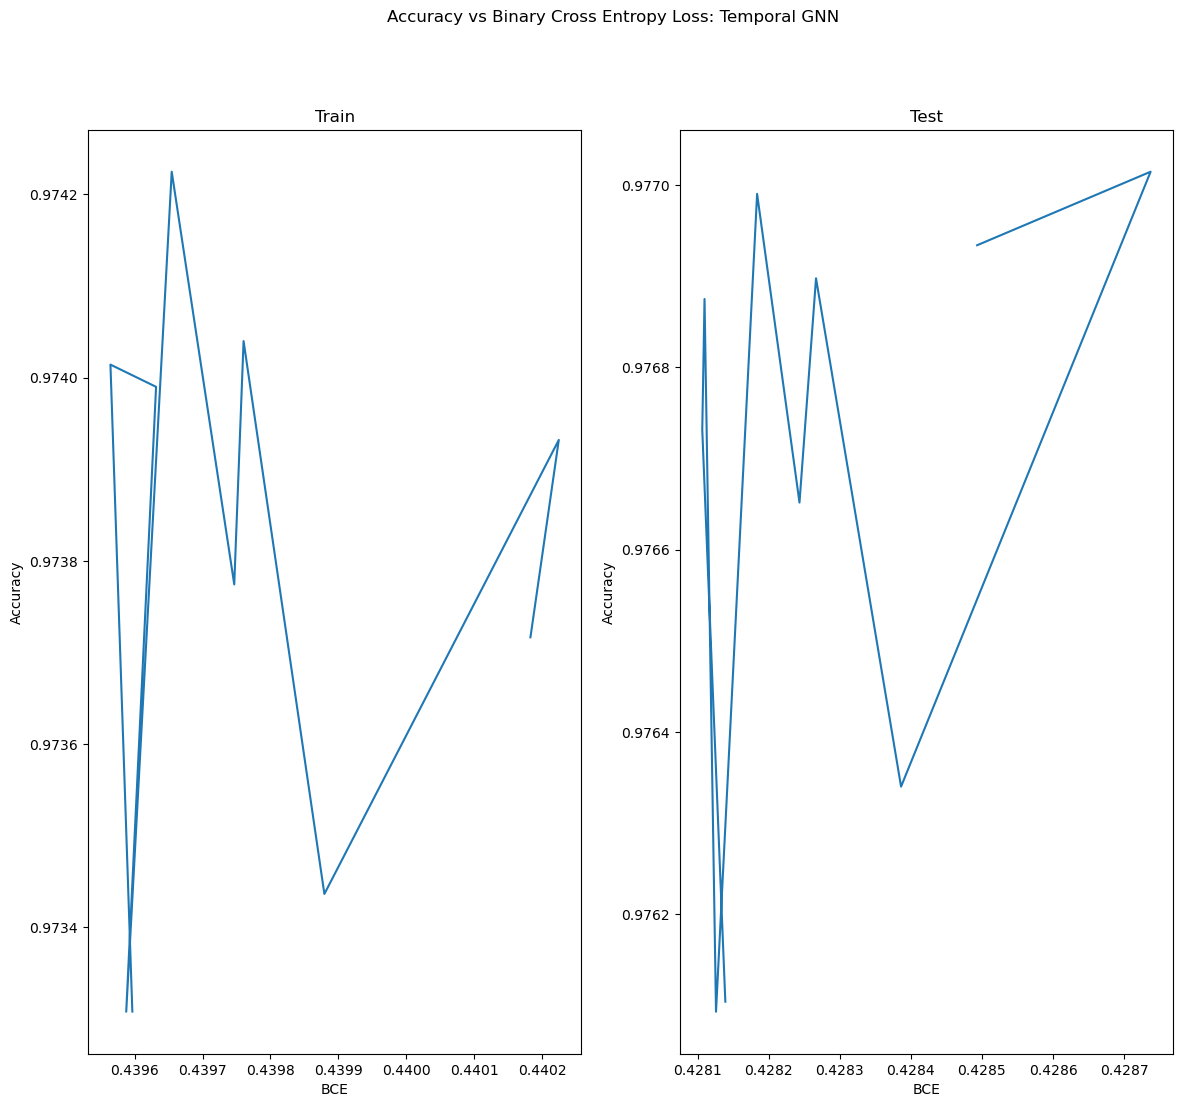

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (14, 12));
ax[0].plot(train_BCE_totals, train_ACC_totals)
ax[0].set_xlabel('BCE')
ax[0].set_ylabel('Accuracy')
ax[0].title.set_text('Train')
ax[1].plot(test_BCE_totals, test_ACC_totals)
ax[1].set_xlabel('BCE')
ax[1].set_ylabel('Accuracy')
ax[1].title.set_text('Test')

fig.suptitle('Accuracy vs Binary Cross Entropy Loss: Temporal GNN')

plt.show()

In [12]:
gc.collect()

0

### 6 Spatial Model with Weather Features <a id='6_Spatial_Model_with_Weather_Features'>

In [13]:
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(11, 16)
        self.conv2 = GCNConv(16, 11)
        self.linear = nn.Linear(11, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [14]:
model2 = GCN()
model2.cuda()
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = t.FloatTensor([1.0, 30.0]).cuda())

In [15]:
n_epochs = 10
train_BCE_totals = []
train_ACC_totals = []
test_BCE_totals = []
test_ACC_totals = []
for epoch in range(n_epochs):
    #Training
    model2.train()
    for data in train_random_loader:
        x = data.x.type(t.cuda.FloatTensor)
        edge_index = data.edge_index.type(t.cuda.LongTensor)
        y = data.y.type(t.cuda.FloatTensor)
        y_pred = model2(x, edge_index)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model2.eval()
    with t.no_grad():
        train_BCEs = []
        train_true_positives = 0
        train_false_positives = 0
        train_false_negatives = 0
        train_true_negatives = 0
        test_BCEs = []
        test_true_positives = 0
        test_false_positives = 0
        test_false_negatives = 0
        test_true_negatives = 0
        for data in train_random_loader:
            x = data.x.type(t.cuda.FloatTensor)
            edge_index = data.edge_index.type(t.cuda.LongTensor)
            y = data.y.type(t.cuda.FloatTensor)
            y_pred = model2(x, edge_index)
            train_BCE = loss_fn(y_pred, y)
            train_BCEs.append(train_BCE.cpu())
            true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
            train_true_positives += true_positives
            train_false_positives += false_positives
            train_false_negatives += false_negatives
            train_true_negatives += true_negatives
        train_BCE_avg = np.array(train_BCEs).mean()
        train_class0_recall = train_true_negatives / (train_true_negatives + train_false_positives)
        train_class0_precision = train_true_negatives / (train_true_negatives + train_false_negatives)
        train_class0_f1 = 2 * (train_class0_precision * train_class0_recall) / (train_class0_precision + train_class0_recall)
        train_class1_recall = train_true_positives / (train_true_positives + train_false_negatives)
        train_class1_precision = train_true_positives / (train_true_positives + train_false_positives)
        train_class1_f1 = 2 * (train_class1_precision * train_class1_recall) / (train_class1_precision + train_class1_recall)
        train_accuracy = (train_true_positives + train_true_negatives) / (train_true_positives + train_false_positives
                                                                         + train_false_negatives + train_true_negatives)
        train_BCE_totals.append(train_BCE_avg)
        train_ACC_totals.append(train_accuracy)
        print("TRAINING DATA")
        print("\t\tprecision\trecall\t\tf1-score")
        print()
        print("Class 0\t\t%.4f\t\t%.4f\t\t%.4f" % (train_class0_precision, train_class0_recall, train_class0_f1))
        print("Class 1\t\t%.4f\t\t%.4f\t\t%.4f" % (train_class1_precision, train_class1_recall, train_class1_f1))
        print("Accuracy\t\t\t\t\t%.4f" % (train_accuracy))
        print()
        print(train_true_positives)
        print(train_false_positives)
        print(train_false_negatives)
        print(train_true_negatives)
        for data in test_random_loader:
            x = data.x.type(t.cuda.FloatTensor)
            edge_index = data.edge_index.type(t.cuda.LongTensor)
            y = data.y.type(t.cuda.FloatTensor)
            y_pred = model2(x, edge_index)
            test_BCE = loss_fn(y_pred, y)
            test_BCEs.append(test_BCE.cpu())
            true_positives, false_positives, false_negatives, true_negatives = ACC(y_pred, y)
            test_true_positives += true_positives
            test_false_positives += false_positives
            test_false_negatives += false_negatives
            test_true_negatives += true_negatives
        test_BCE_avg = np.array(test_BCEs).mean()
        test_class0_recall = test_true_negatives / (test_true_negatives + test_false_positives)
        test_class0_precision = test_true_negatives / (test_true_negatives + test_false_negatives)
        test_class0_f1 = 2 * (test_class0_precision * test_class0_recall) / (test_class0_precision + test_class0_recall)
        test_class1_recall = test_true_positives / (test_true_positives + test_false_negatives)
        test_class1_precision = test_true_positives / (test_true_positives + test_false_positives)
        test_class1_f1 = 2 * (test_class1_precision * test_class1_recall) / (test_class1_precision + test_class1_recall)
        test_accuracy = (test_true_positives + test_true_negatives) / (test_true_positives + test_false_positives
                                                                        + test_false_negatives + test_true_negatives)
        test_BCE_totals.append(test_BCE_avg)
        test_ACC_totals.append(test_accuracy)
        print("TESTING DATA")
        print("\t\tprecision\trecall\t\tf1-score")
        print()
        print("Class 0\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class0_precision, test_class0_recall, test_class0_f1))
        print("Class 1\t\t%.4f\t\t%.4f\t\t%.4f" % (test_class1_precision, test_class1_recall, test_class1_f1))
        print("Accuracy\t\t\t\t\t%.4f" % (test_accuracy))
        print()
        print(test_true_positives)
        print(test_false_positives)
        print(test_false_negatives)
        print(test_true_negatives)
    print("Epoch %d: train BCE %.4f, test BCE %.4f" % (epoch, train_BCE_avg, test_BCE_avg))
    print("---------------------------------------------------------")
    gc.collect()

TRAINING DATA
		precision	recall		f1-score

Class 0		0.9959		0.9963		0.9961
Class 1		0.1093		0.0989		0.1039
Accuracy					0.9923

53114
432706
483888
117362292
TESTING DATA
		precision	recall		f1-score

Class 0		0.9959		0.9963		0.9961
Class 1		0.1085		0.0979		0.1029
Accuracy					0.9923

17537
144062
161613
39120788
Epoch 0: train BCE 0.4705, test BCE 0.4704
---------------------------------------------------------
TRAINING DATA
		precision	recall		f1-score

Class 0		0.9988		0.9754		0.9870
Class 1		0.1221		0.7500		0.2100
Accuracy					0.9744

402748
2895698
134254
114899300
TESTING DATA
		precision	recall		f1-score

Class 0		0.9988		0.9754		0.9870
Class 1		0.1224		0.7511		0.2105
Accuracy					0.9744

134568
964917
44582
38299933
Epoch 1: train BCE 0.4525, test BCE 0.4525
---------------------------------------------------------
TRAINING DATA
		precision	recall		f1-score

Class 0		0.9989		0.9753		0.9869
Class 1		0.1227		0.7586		0.2113
Accuracy					0.9743

407391
2912349
129611
114882649
TES

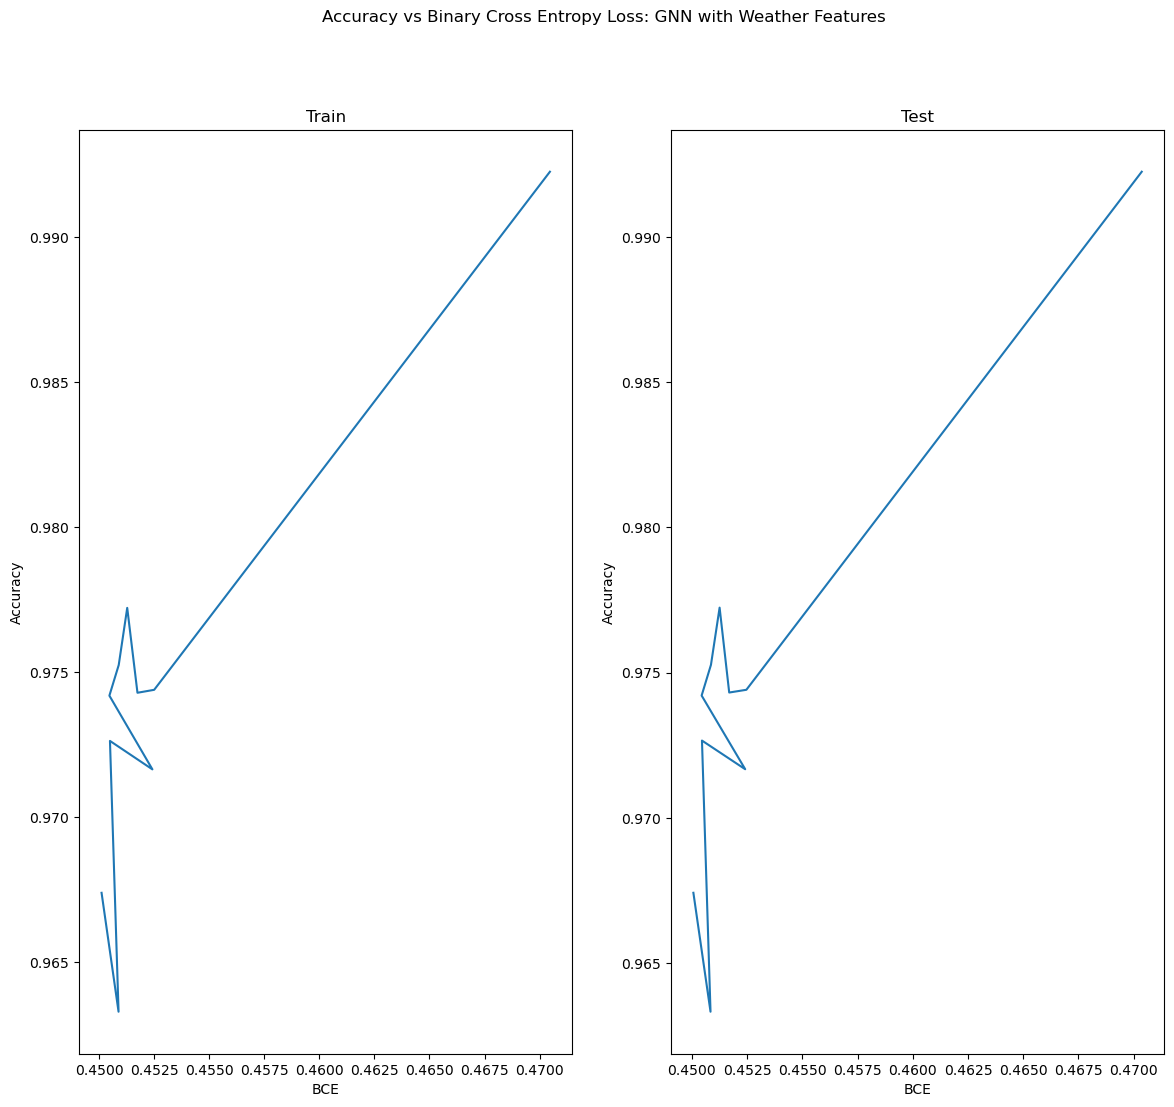

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (14, 12));
ax[0].plot(train_BCE_totals, train_ACC_totals)
ax[0].set_xlabel('BCE')
ax[0].set_ylabel('Accuracy')
ax[0].title.set_text('Train')
ax[1].plot(test_BCE_totals, test_ACC_totals)
ax[1].set_xlabel('BCE')
ax[1].set_ylabel('Accuracy')
ax[1].title.set_text('Test')

fig.suptitle('Accuracy vs Binary Cross Entropy Loss: GNN with Weather Features')

plt.show()

### 8 Best Model <a id='8_Best_Model'>

### Conclusion <a id='Conclusion'>

The final model...